In [1]:
import sisl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch


- band

In [ ]:
H_fdf  = sisl.Hamiltonian.read('/data/zjj/transiesta_cal/hBN_formal/hBN_band/RUN.fdf')
band = sisl.BandStructure(H_fdf, [[0., 0.,0.],[1/2,0,0.],[1./3, 1./3,0.],[0., 0.,0.]], \
                          300,[r'$\Gamma$', 'M', 'K', r'$\Gamma$']) 
eigs = band.apply.array.eigh()-0.274801333E+01 # subtract the Fermi energy

# Retrieve the tick-marks and the linear k points
xtick, xtick_label = band.lineartick()
lk = band.lineark()
# plt.plot(lk, eigs,'o',color='grey')
plt.plot(lk, eigs,color='b')
plt.ylabel('E-EF [eV]')
plt.gca().xaxis.set_ticks(xtick)
plt.gca().set_xticklabels(xtick_label)
plt.ylim(-25,15)
# plt.hlines(-0.339597552E+01,0,8,colors='r',linestyles='dashed')
# Also plot x-major lines at the ticks
ymin, ymax = plt.gca().get_ylim()
for tick in xtick:
    plt.plot([tick,tick], [ymin,ymax], 'k')

plt.title('SIESTA:hBN   Ef = -2.748013 eV')

- Transmission

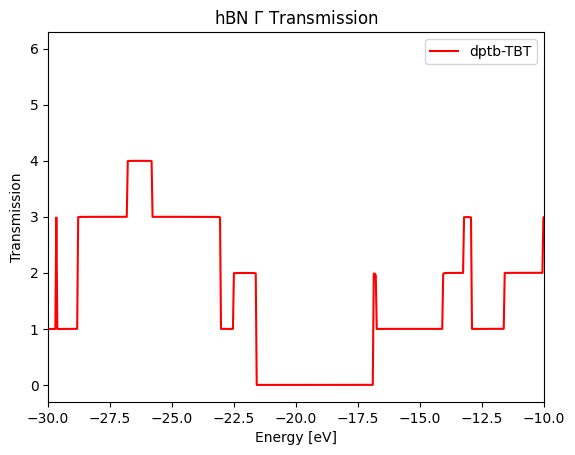

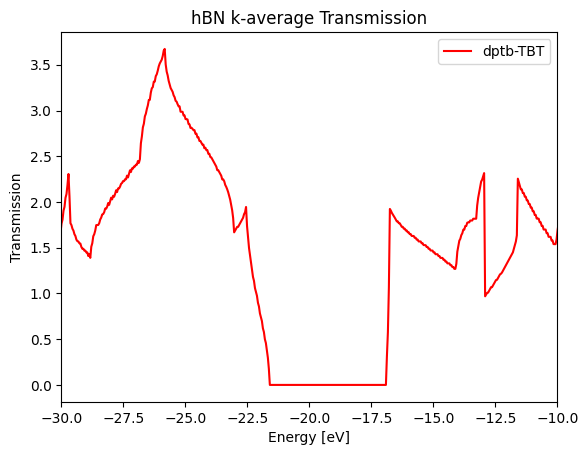

In [7]:
tbt_dptb = sisl.get_sile('./data/dptb_TBT_results/dptb.TBT.nc')


plt.plot(tbt_dptb.E, tbt_dptb.transmission(kavg=tbt_dptb.kindex([0,0,0])),label=r'dptb-TBT',color='r')
plt.title(r'hBN $\Gamma$ Transmission')
plt.ylabel('Transmission'); plt.xlabel('Energy [eV]')
plt.legend()
plt.xlim(-30,-10)
plt.show()

plt.plot(tbt_dptb.E, tbt_dptb.transmission(),label=r'dptb-TBT',color='r')
plt.title(r'hBN k-average Transmission')
plt.ylabel('Transmission'); plt.xlabel('Energy [eV]')
plt.legend()
plt.xlim(-30,-10)
plt.show()

- non-self-consistent current

Text(0.5, 1.0, 'hBN I-V')

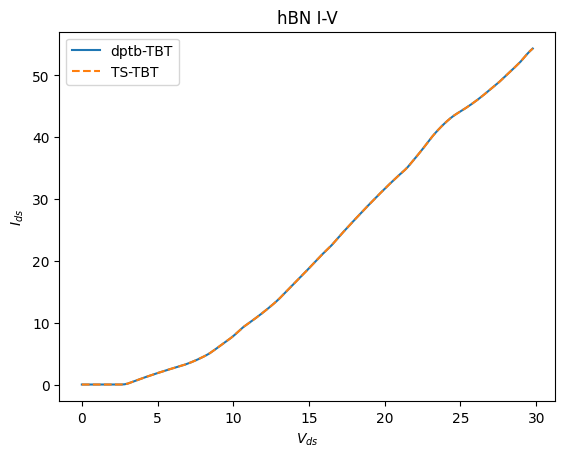

In [13]:

from dptb.utils.constants import Boltzmann, eV2J
from scipy.integrate import simpson
def _cal_current_nscf_(energy_grid, tc):
    '''calculates the non self consistent field (nscf) current.

    Parameters
    ----------
    ee
        unit energy grid points in NEGF calculation
    tc
        Transmission calculated at zero bias voltage
    Returns
    -------
    vv
        voltage range
    cc
        calculated current
    '''
    e_T = 300
    kBT = Boltzmann * e_T / eV2J

    mu = 0; lead_L_efermi = 0; lead_R_efermi = 0
    f = lambda x,mu: 1 / (1 + torch.exp((x - mu) / kBT))

    emin = energy_grid.min()
    emax = energy_grid.max()
    vmin = emin + 4*kBT
    vmax = emax - 4*kBT
    vm = 0.5 * (vmin+vmax)
    vmid = vm - vmin
    
    vv = torch.linspace(start=0., end=vmid, steps=int(vmid / 0.1)+1) * 2
    cc = []

    for dv in vv * 0.5:
        I = simpson((f(energy_grid+mu, lead_L_efermi-vm+dv) - f(energy_grid+mu, lead_R_efermi-vm-dv)) * tc, energy_grid)
        cc.append(I)

    return vv, cc

Erange = torch.from_numpy(tbt_TS.E)
trans =torch.from_numpy(tbt_TS.transmission())
voltage, current = _cal_current_nscf_(Erange, trans)


Erange2 = torch.from_numpy(tbt_dptb.E+delta_E)
trans2 = torch.from_numpy(tbt_dptb.transmission())
voltage2, current2 = _cal_current_nscf_(Erange, trans)

plt.plot(voltage2,current2,label='dptb-TBT')
plt.plot(voltage,current,'--',label='TS-TBT')
plt.legend()
plt.xlabel(r'$V_{ds}$')
plt.ylabel(r'$I_{ds}$')
plt.title('hBN I-V')
